# 의사결정트리 분류 기본코드

## #01. 준비작업

### [1] 패키지 가져오기

시각화를 위해서 `dtreeviz` 패키지가 필요하다

In [39]:
import warnings
warnings.filterwarnings('ignore')

# Intel SKlearn 하드웨어 가속 패치 설정
import sys
if sys.platform == 'win32':
    from sklearnex import patch_sklearn
    patch_sklearn()

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.classification import *

from sklearn.tree import DecisionTreeClassifier # 분석알고리즘
import dtreeviz
from sklearn.tree import export_text, plot_tree

from sklearn import tree
from collections import Counter
from itertools import chain, combinations


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## #02. 이진분류 - 피마 인디언 당뇨병 데이터 셋

### [1] 데이터 가져오기

In [38]:
origin = my_read_excel("https://data.hossam.kr/mldata/pima_indians_diabetes.xlsx", categories=['Outcome'], info=False)

### [2] 데이터 전처리

1. 종속변수 라벨링 및 형변환
2. 훈련/검증 데이터 분리

In [40]:
# 정제 대상 필드명
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

# `0`값을 결측치로 대체후 평균으로 다시 치환
df = origin.copy()
df[zero_features] = df[zero_features].replace(0, np.nan)
df2 = my_replace_missing_value(df)

df2['Outcome'] = df2['Outcome'].astype('int')

x_train, x_test, y_train, y_test = my_train_test_split(df2, yname='Outcome', test_size=0.2, scalling=False)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [41]:
df2['Outcome'].unique()

array([1, 0])

### [3] 의사결정나무 분류 모델 구현

| 하이퍼파라미터       | 설명 | 기본값 | 추천 사항 | `GridSearchCV` 추천값 |
|---------------------|------|--------|-----------|------------------------|
| * `criterion`         | 노드를 분할할 기준. 'gini'는 지니 불순도를, 'entropy'는 정보 이득을 사용함 | 'gini' | 문제에 따라 다르지만, 일반적으로 두 기준 중 하나를 선택해서 실험해보는 걸 권장 | `{'criterion': ['gini', 'entropy']}` |
| `splitter`          | 각 노드에서 분할을 선택하는 방식. 'best'는 최선의 분할을 찾으려고 하고, 'random'은 무작위로 분할을 선택함. | 'best' | 대규모 데이터셋이나 무작위성을 추가하고 싶을 때 'random'을 고려할 수 있음 | `{'splitter': ['best', 'random']}` |
| `max_depth`         | 트리의 최대 깊이를 제한. 깊이가 깊어질수록 모델은 더 복잡해지고 과적합될 가능성이 높아짐 | None   | 과적합을 방지하기 위해 적절한 값으로 설정하는 것이 중요. 데이터와 문제에 따라 최적의 값을 찾아봐함 | `{'max_depth': [None, 10, 20, 30, 40, 50]}` |
| * `min_samples_split` | 노드를 분할하기 위해 필요한 최소 샘플 수. 이 값이 클수록 분할이 적게 일어나 트리가 간단해짐 | 2      | 불필요한 분할을 줄이기 위해 이 값을 조정할 수 있음. 크로스 밸리데이션을 통해 적절한 값을 찾아봐야 함 | `{'min_samples_split': [2, 5, 10]}` |
| * `min_samples_leaf`  | 리프 노드가 되기 위해 필요한 최소 샘플 수. 이 값도 클수록 모델이 단순해지고 과적합을 방지할 수 있음 | 1      | 리프 노드의 크기를 조정하여 과적합을 방지할 수 있음 데이터의 특성에 맞게 조정해보는 걸 권장. | `{'min_samples_leaf': [1, 2, 4]}` |
| `max_features`      | 최적의 분할을 찾기 위해 고려할 최대 특성 수. | None   | 이 값을 조정함으로써 모델의 다양성을 높이고 과적합을 줄일 수 있음. 하지만, 너무 낮게 설정하면 모델 성능이 떨어질 수 있음. | `{'max_features': ['auto', 'sqrt', 'log2', None]}` |

In [4]:
estimator = DecisionTreeClassifier(random_state=777, max_depth=3)
estimator.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=777)

### [4] 결과 확인

#### (1) 텍스트 형태

In [5]:
et = export_text(estimator, feature_names= x_train.columns, 
                 class_names=['음성', '양성'])

print(et)

                 

|--- Glucose <= 143.50
|   |--- BMI <= 26.95
|   |   |--- BMI <= 26.35
|   |   |   |--- class: 음성
|   |   |--- BMI >  26.35
|   |   |   |--- class: 음성
|   |--- BMI >  26.95
|   |   |--- Glucose <= 107.50
|   |   |   |--- class: 음성
|   |   |--- Glucose >  107.50
|   |   |   |--- class: 음성
|--- Glucose >  143.50
|   |--- Glucose <= 154.50
|   |   |--- Glucose <= 152.50
|   |   |   |--- class: 양성
|   |   |--- Glucose >  152.50
|   |   |   |--- class: 음성
|   |--- Glucose >  154.50
|   |   |--- Insulin <= 629.50
|   |   |   |--- class: 양성
|   |   |--- Insulin >  629.50
|   |   |   |--- class: 음성



#### (2) 그래픽 시각화

기존에 사용되던 `Graphivz`는 사용을 위해서 별도의 그래픽 처리 프로그램을 설치해야 하는 번거로움이 있어서 최근에는 이를 대체하기 위한 `plot_tree` 함수를 주로 사용한다.

기본 파라미터는 `export_text()`와 동일.

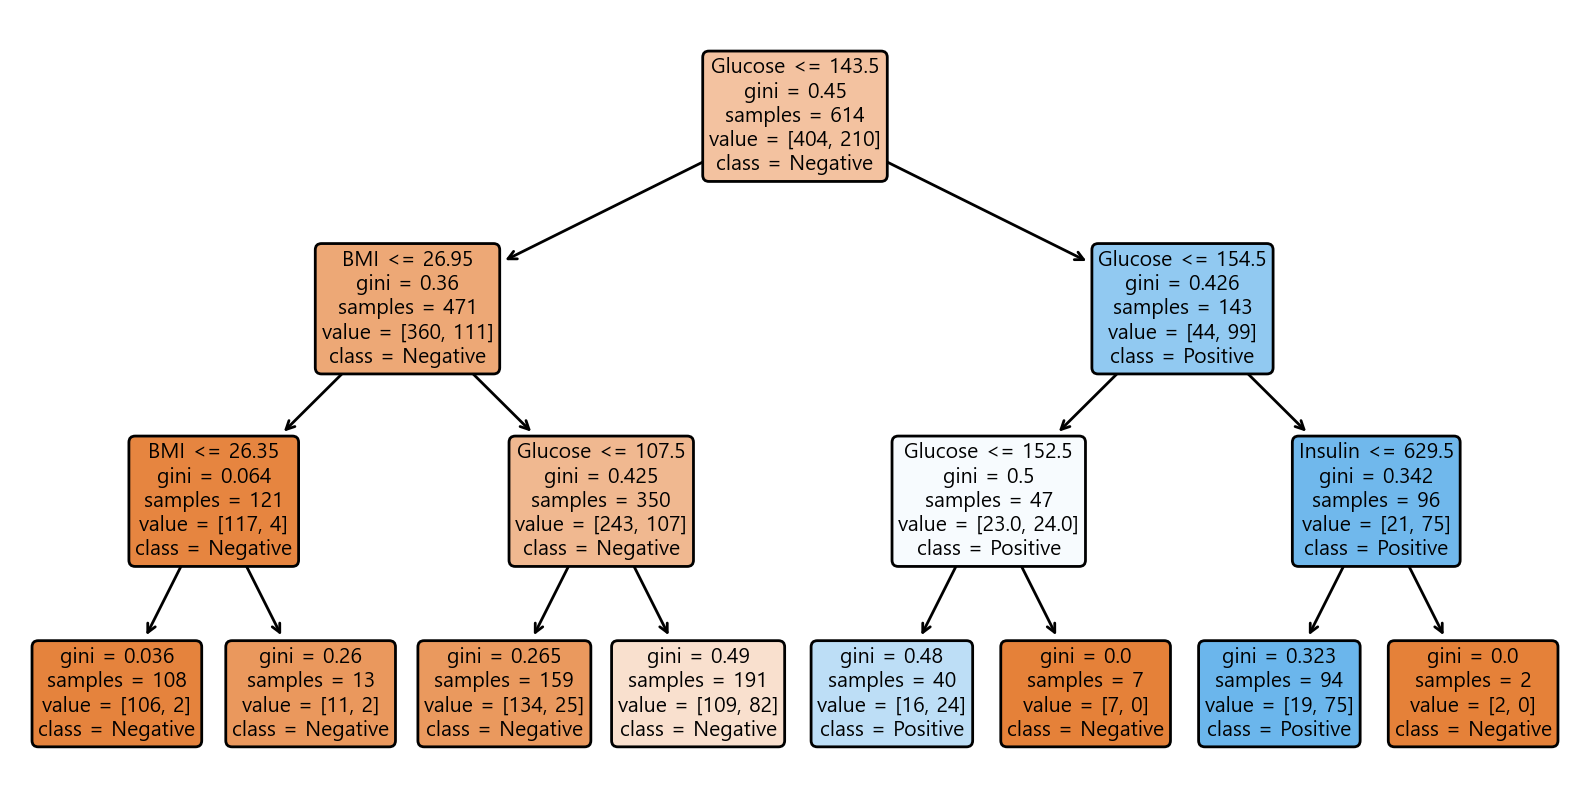

In [8]:
plt.figure(figsize=(10,5))
plot_tree(estimator, feature_names = list(x_train.columns),
          class_names = ['Negative','Positive'],
            rounded=True,
            filled=True)
plt.show()
plt.close()

#### (3) 고급 시각화

`dtreeviz` 패키지의 설치와 참조가 필요하다.

> 한글 지원하지 않음

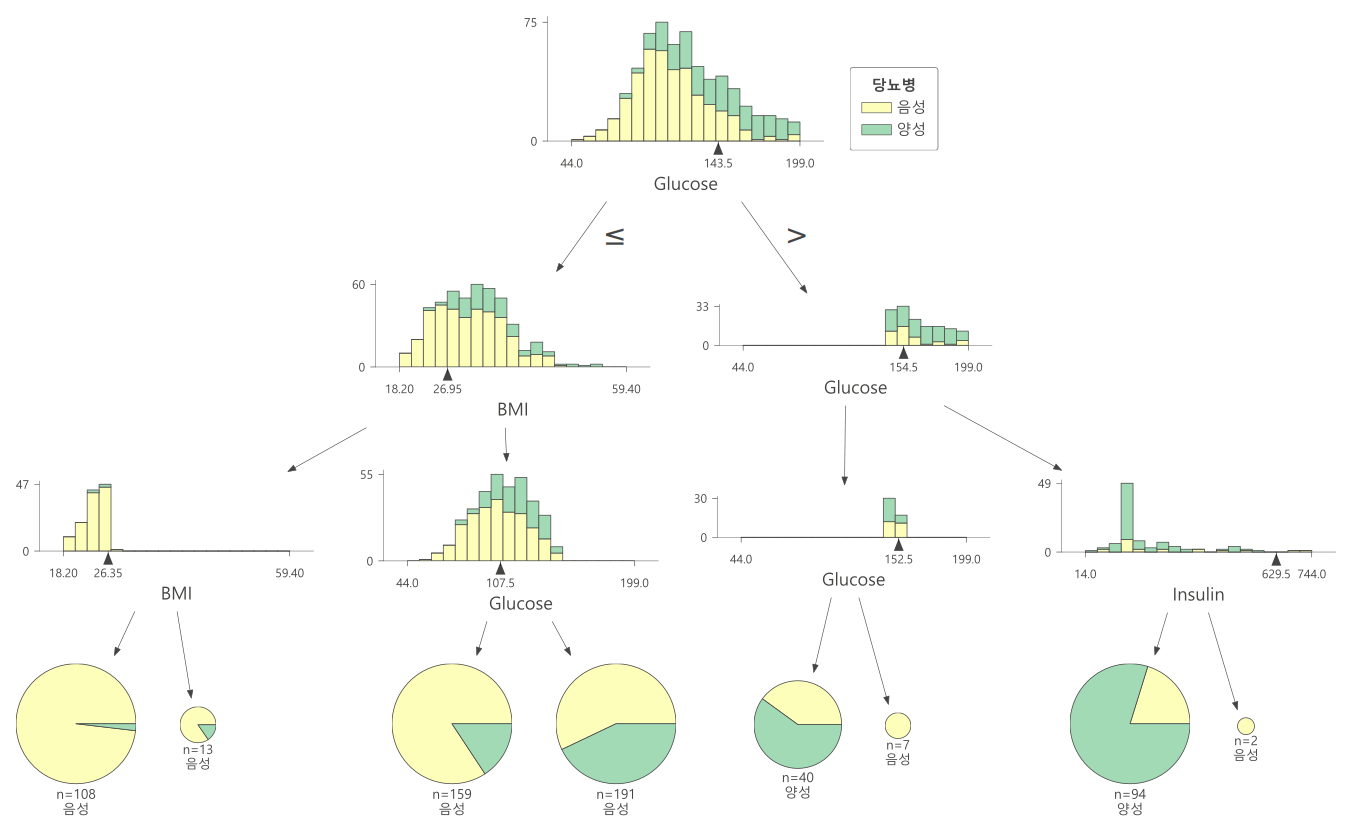

In [18]:
viz = dtreeviz.model(estimator,
                     X_train = x_train,
                     y_train = y_train,
                     target_name='당뇨병',
                     feature_names = list(x_train.columns),
                     class_names =['음성','양성'],
                     )
viz.view(scale=2.0, fontname='Malgun Gothic')

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.762215 |     0.746753 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.738806 |     0.806452 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.471429 |     0.431034 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |    0.0866337 |       0.0625 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.913366 |       0.9375 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.575581 |     0.561798 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.820539 |      0.79445 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+--

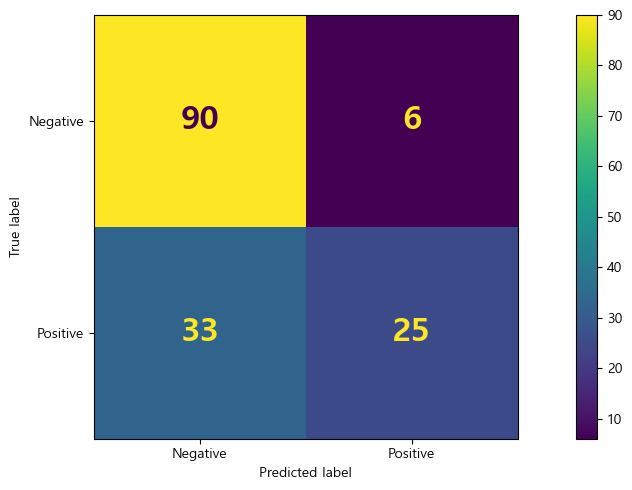

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



[Roc Curve]


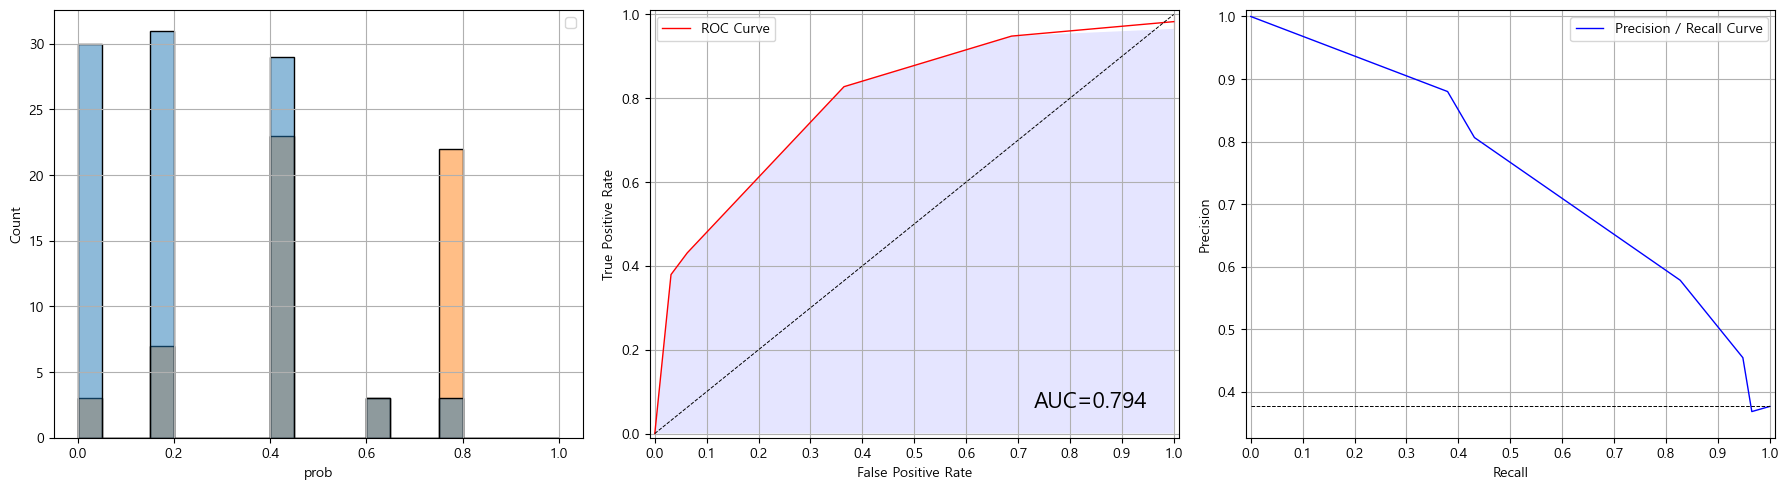


[학습곡선]


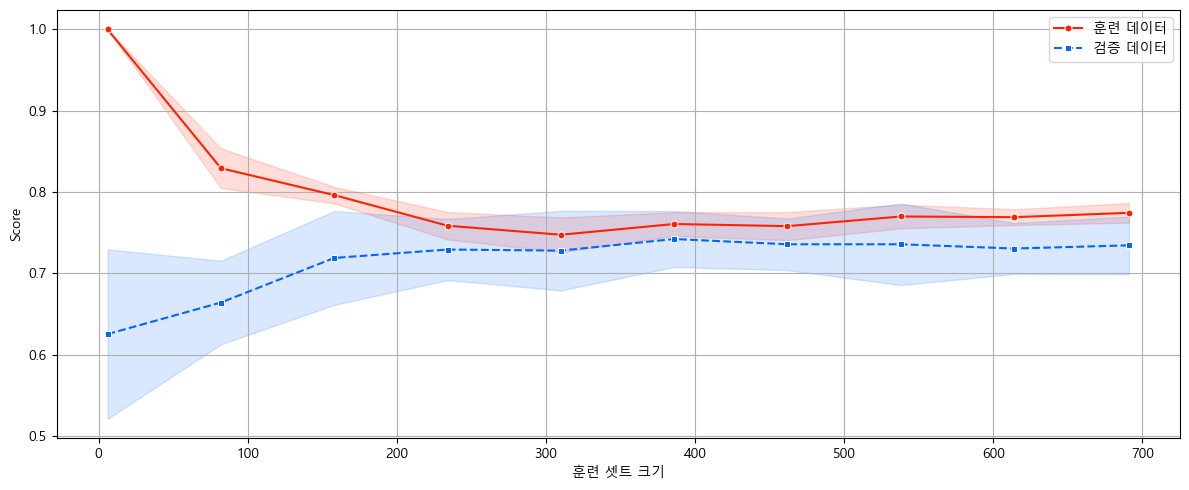

In [11]:
my_classification_result(estimator, x_train,y_train,x_test,y_test)

In [12]:
my_classification(x_train,y_train,x_test,y_test)

<class 'sklearn.naive_bayes.GaussianNB'>는 n_jobs를 허용하지 않음
+----------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------+
|                      |   의사결정계수(Pseudo R2) |   정확도(Accuracy) |   정밀도(Precision) |   재현율(Recall) |   위양성율(Fallout) |   특이성(TNR) |   F1 Score |      AUC |
|----------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------|
| GaussianNB           |                         0 |           0.772727 |            0.716981 |         0.655172 |             0.15625 |       0.84375 |   0.684685 | 0.873743 |
| LogisticRegression   |                  0.325603 |           0.766234 |            0.761905 |         0.551724 |            0.104167 |      0.895833 |       0.64 | 0.866739 |
| KNeighborsClassifier |                         0 |            0.74026 |      

In [ ]:
C:/Users/Jihwan/Desktop/01Class/E.추론통계/E.InferentialStatistics/수업자료

In [19]:
origin = my_read_excel('C:/Users/Jihwan/Desktop/01Class/E.추론통계/E.InferentialStatistics/수업자료/iris.xlsx')
origin.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sepal.Length  150 non-null    float64
 1   Sepal.Width   150 non-null    float64
 2   Petal.Length  150 non-null    float64
 3   Petal.Width   150 non-null    float64
 4   Species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None

데이터프레임 상위 5개 행
+----+----------------+---------------+----------------+---------------+-----------+
|    |   Sepal.Length |   Sepal.Width |   Petal.Length |   Petal.Width | Species   |
|----+----------------+---------------+----------------+---------------+-----------|
|  0 |            5.1 |           3.5 |            1.4 |           0.2 | setosa    |
|  1 |            4.9 |             3 |            1.4 |           0.2 | setosa    |
|  2 |            4.7 |           3.2 |            1.3 |           0.2 | setosa    |
|  3 |      

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [23]:
x_train, x_test, y_train, y_test = my_train_test_split(origin, yname='Species', test_size=0.2, scalling=False)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((120, 4), (30, 4), (120,), (30,))

In [24]:
estimator = DecisionTreeClassifier(random_state=777, max_depth=3)
estimator.fit(x_train, y_train)
                    

DecisionTreeClassifier(max_depth=3, random_state=777)

In [26]:
origin['Species'].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

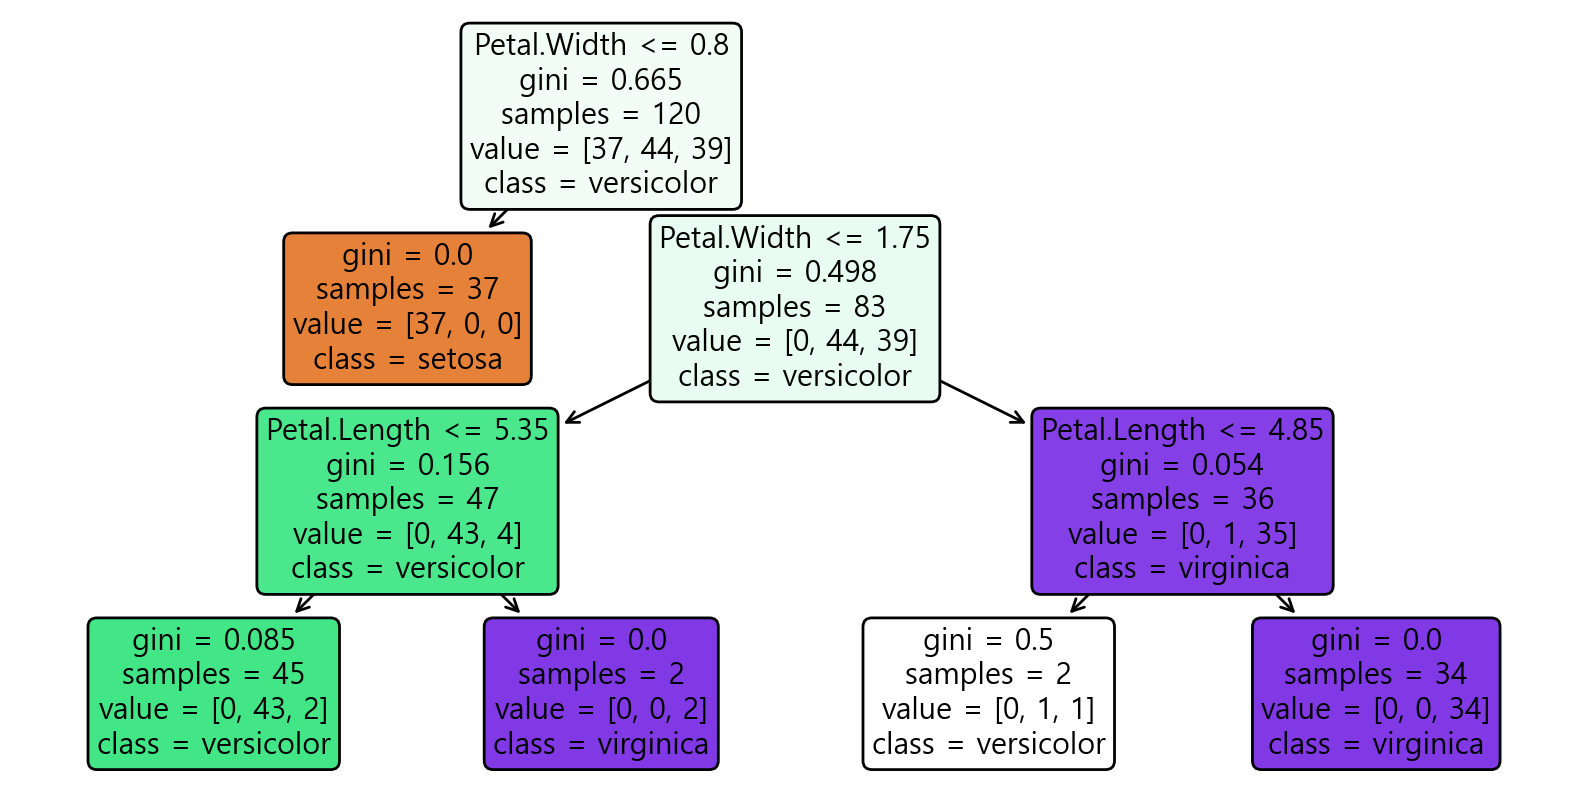

In [27]:
plt.figure(figsize=(10,5))
plot_tree(estimator, feature_names = list(x_train.columns),
          class_names = ['setosa', 'versicolor', 'virginica'],
            rounded=True,
            filled=True)
plt.show()
plt.close()

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |        0.975 |     0.933333 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.978723 |     0.916667 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |        0.975 |     0.939394 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| F1 Score          |     0.975678 |     0.919048 | 정밀도와 재현율의 조화평균                                |
| AUC(ovo)          |     0.991162 |     0.984848 | One vs One에 대한 AUC로, 1에 가까울수록 좋은 모델         |
| AUC(ovr)          |     0.990663 |     0.988271 | One vs Rest에 대한 AUC로, 1에 가까울수록 좋은 모델        |
+-------------------+--------------+--------------+-------------------------------------

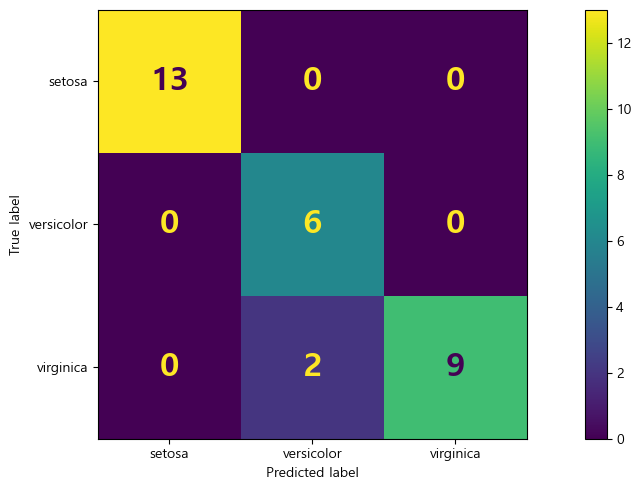


[Roc Curve]


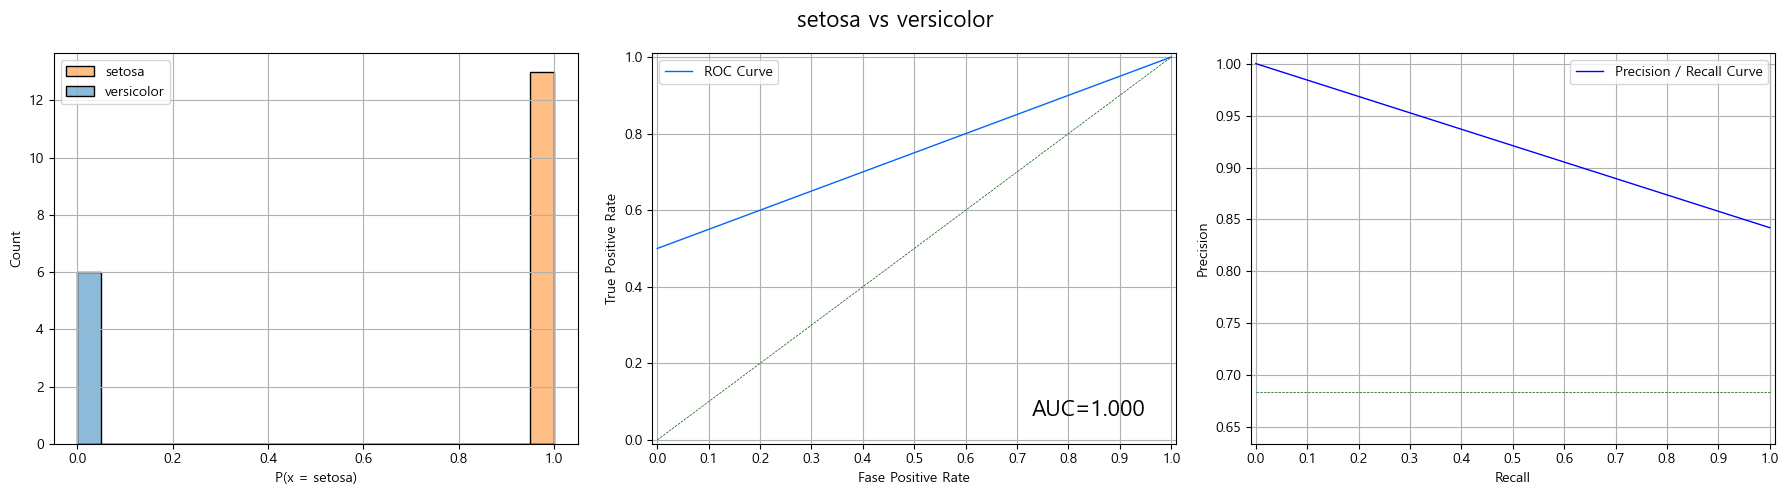

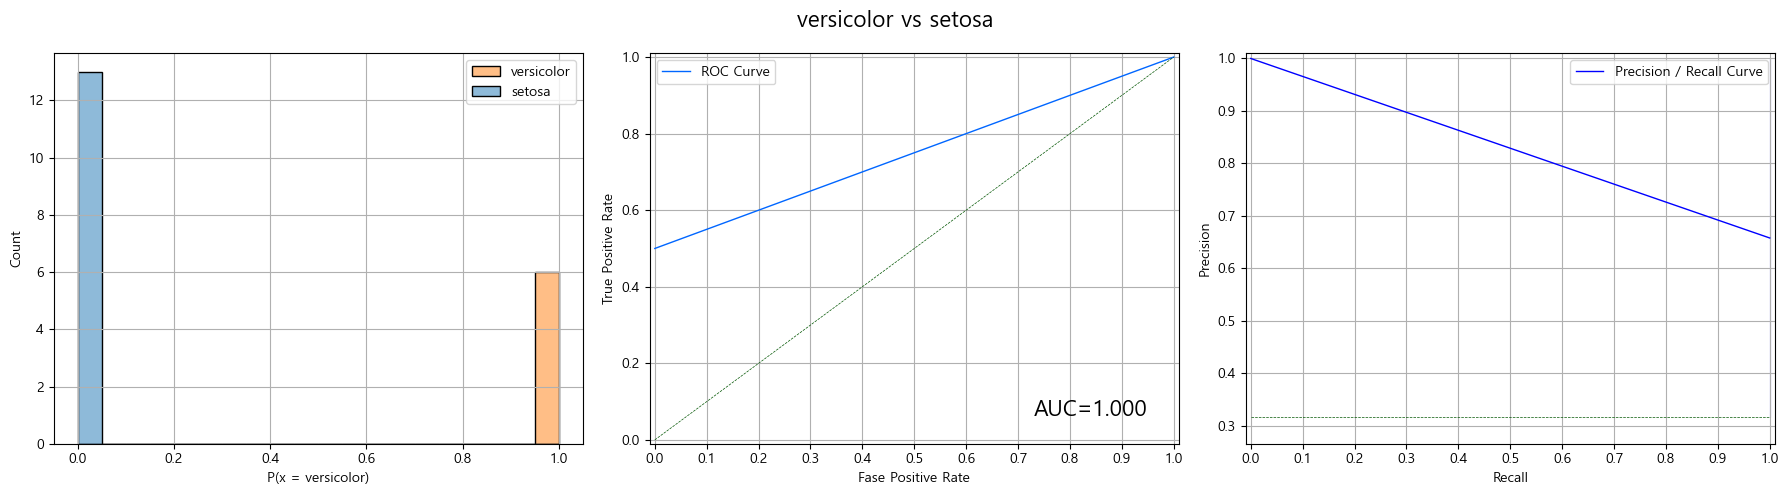

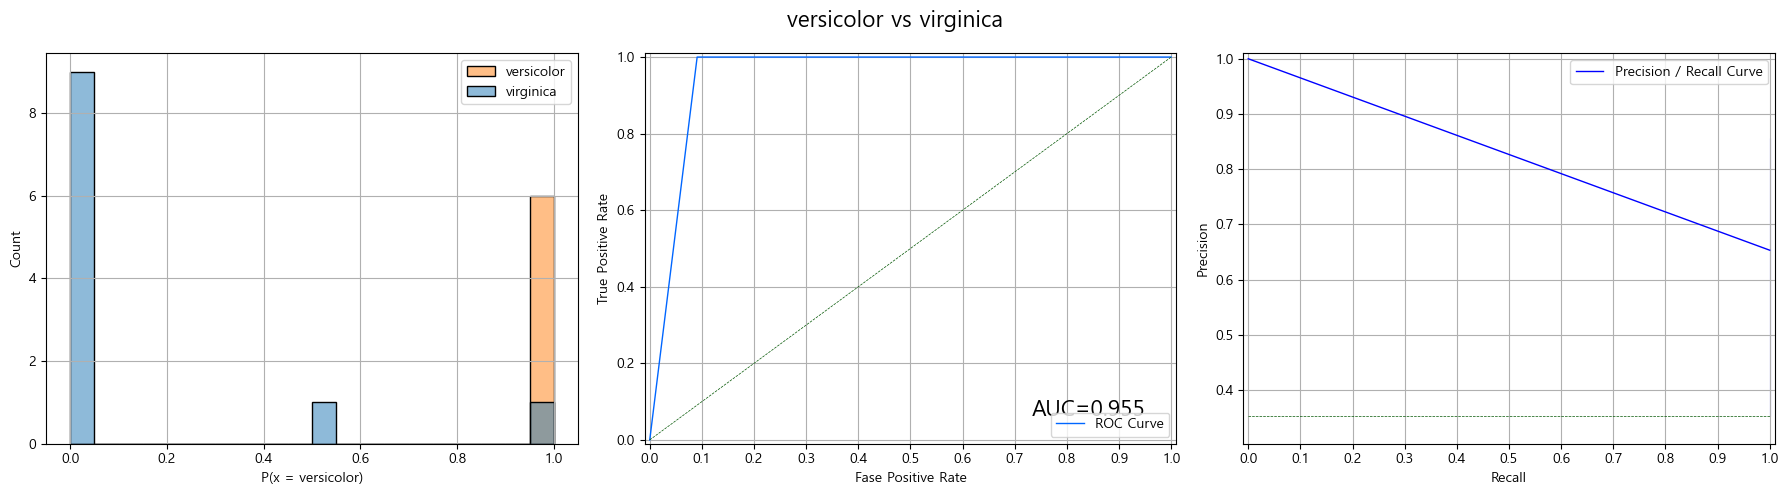

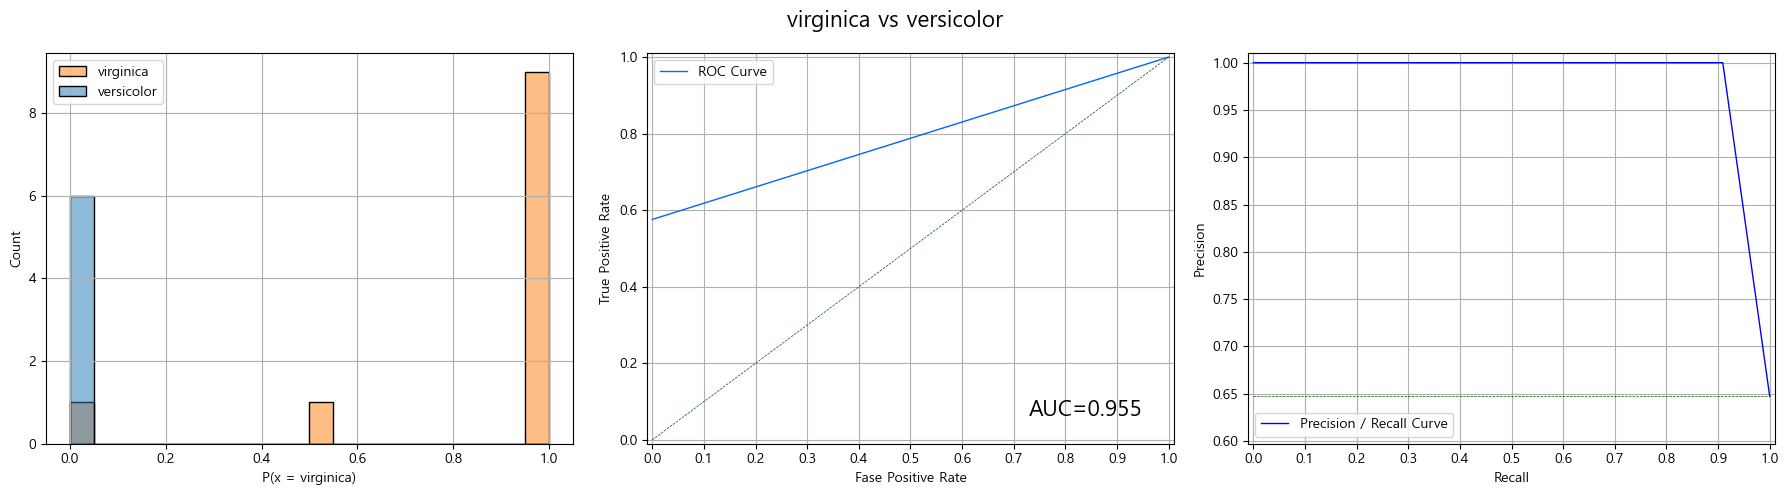

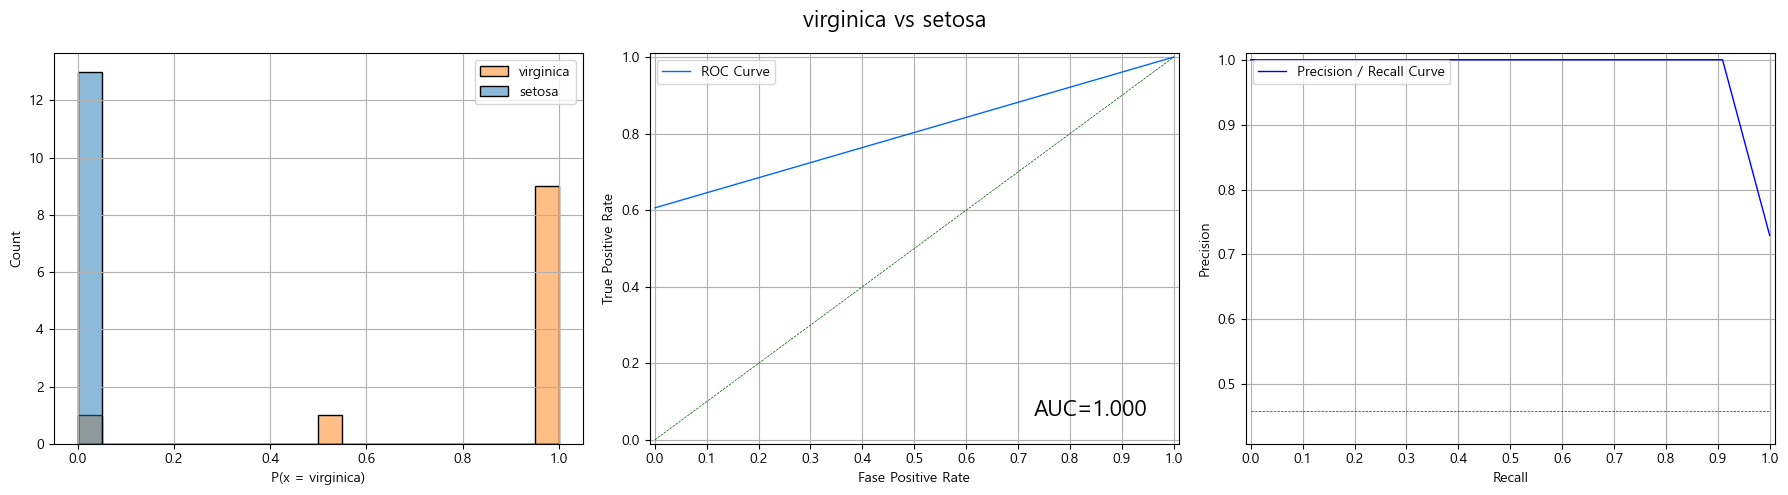

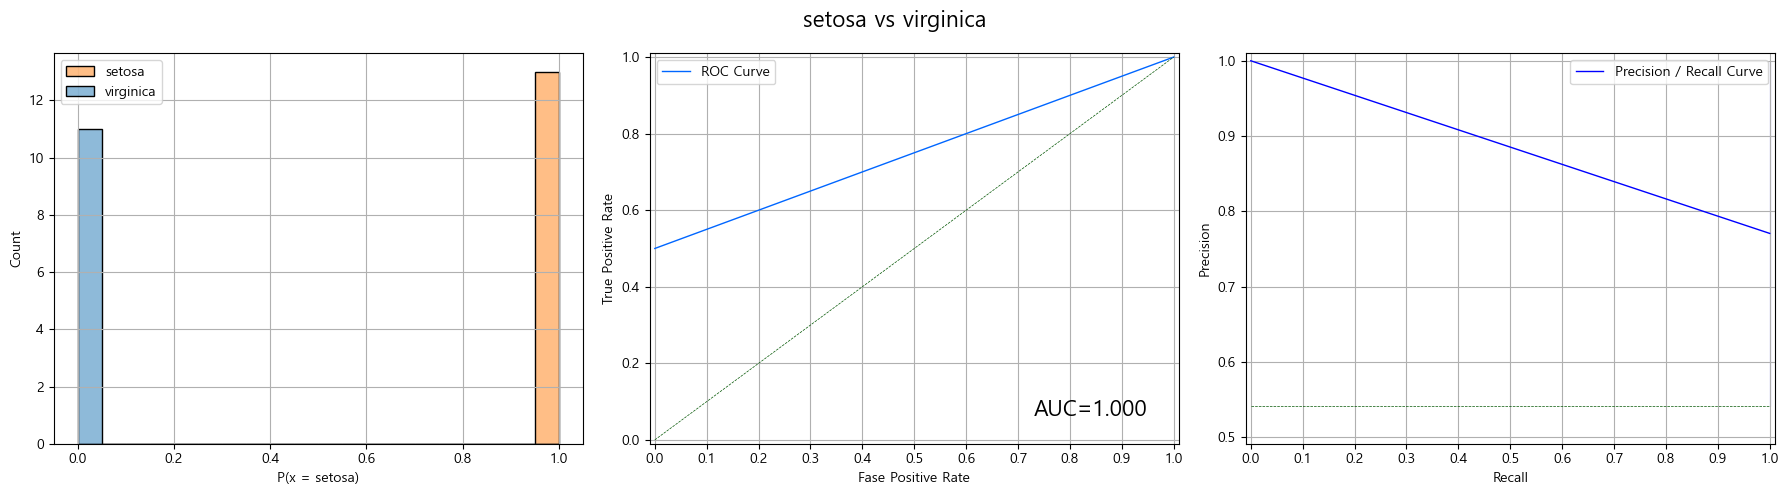

mean roc auc ovo: 0.9848


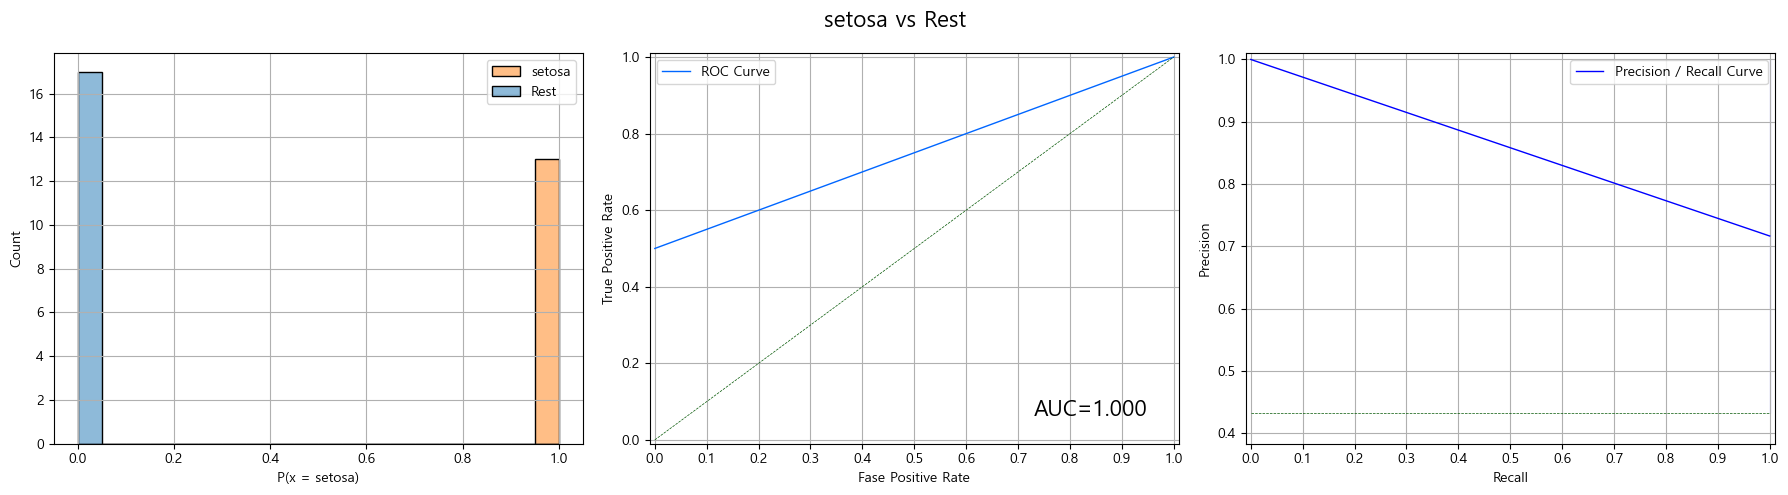

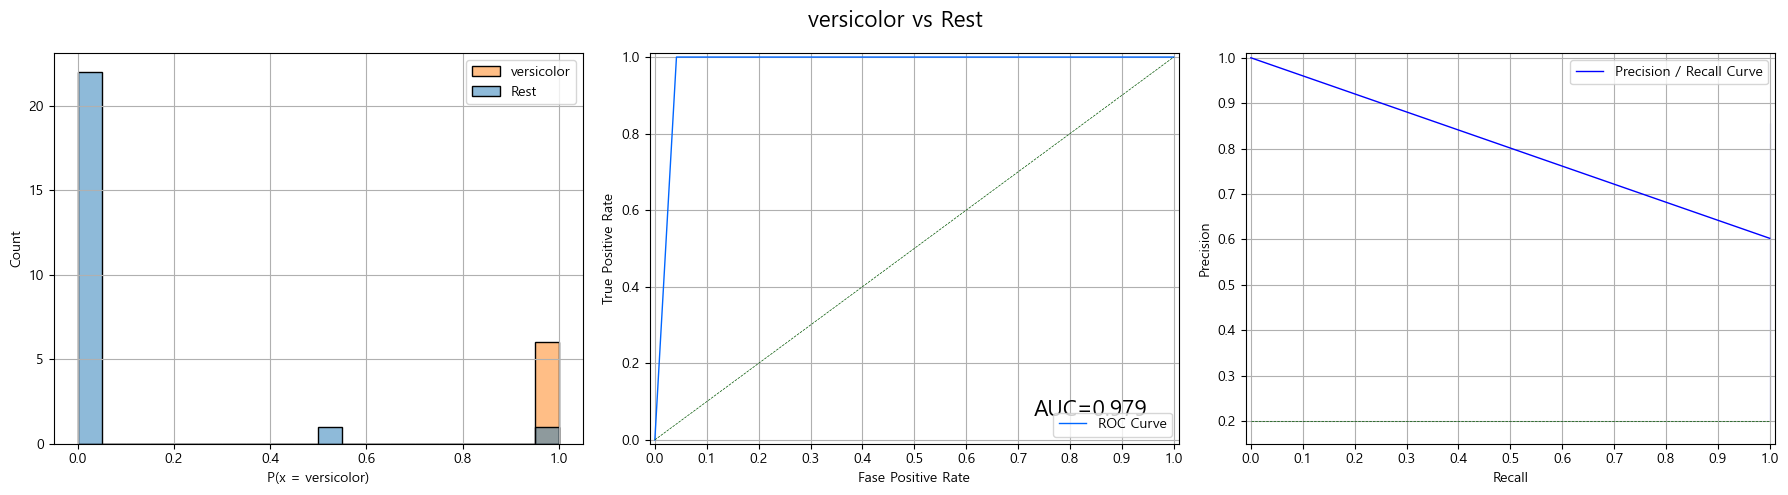

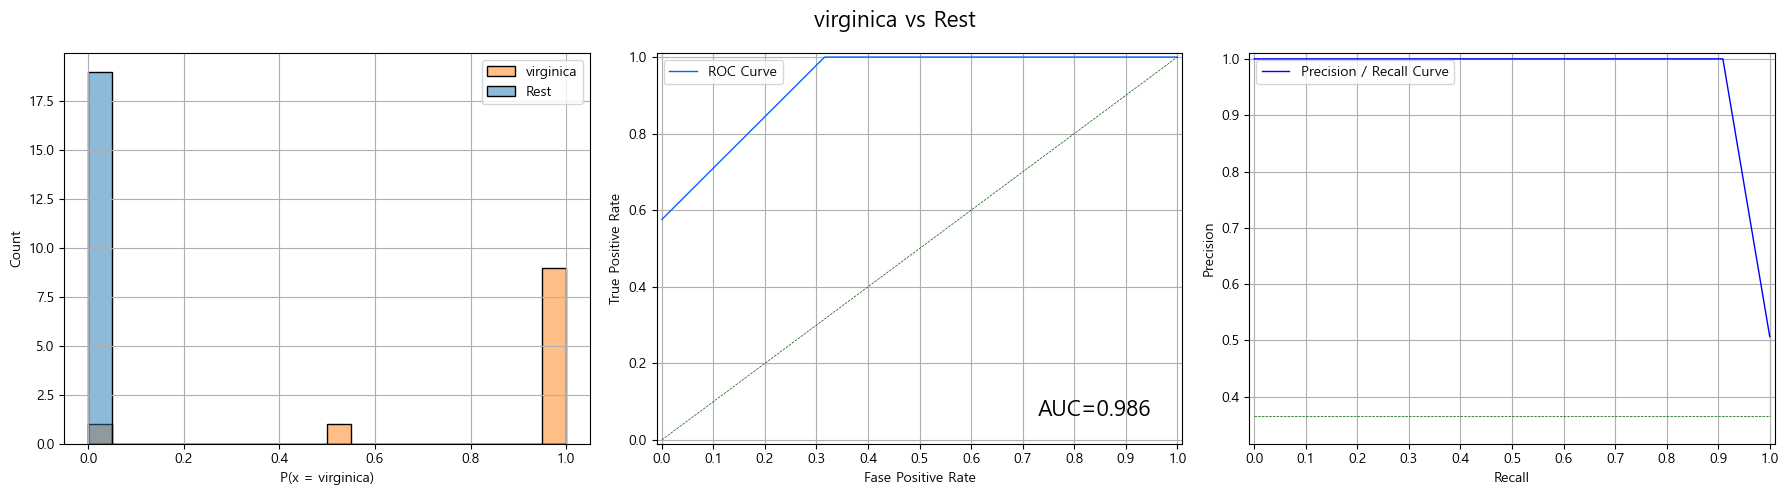

mean roc auc ovo: 0.9883

[학습곡선]


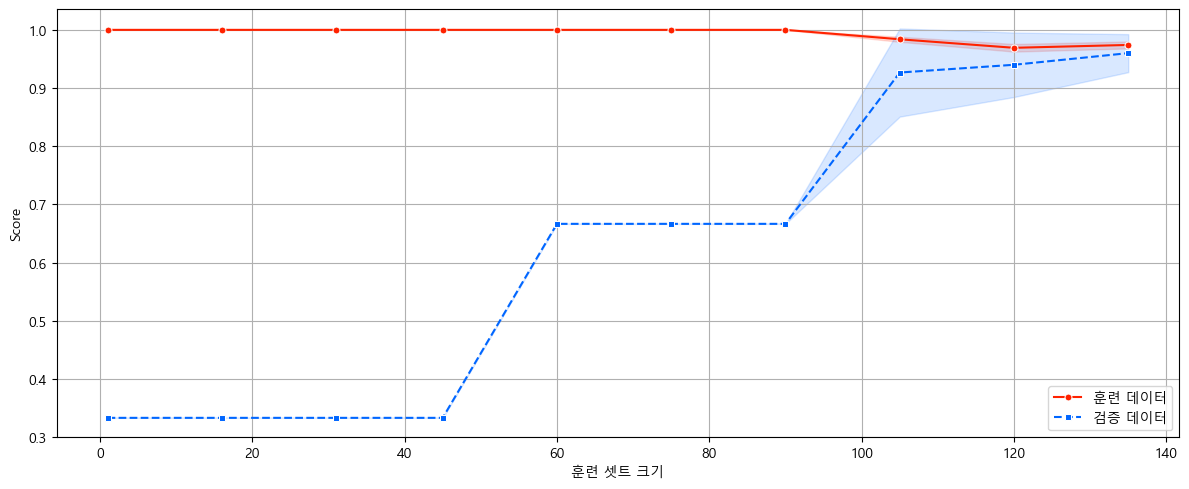

In [30]:
my_classification_result(estimator, x_train, y_train, x_test, y_test)

In [29]:
viz = dtreeviz.model(estimator,
                     X_train = x_train,
                     y_train = y_train,
                     target_name='Species',
                     feature_names = list(x_train.columns),
                     class_names =['setosa', 'versicolor', 'virginica'],
                     )
viz.view(scale=2.0)

UFuncTypeError: ufunc 'less_equal' did not contain a loop with signature matching types (<class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.StrDType'>) -> None

<class 'sklearn.tree._classes.DecisionTreeClassifier'>는 n_jobs를 허용하지 않음
[교차검증 TOP5]
+----+---------------------+--------------------+-------------+-------------+-------------------+
|    |   min_samples_split |   min_samples_leaf |   max_depth | criterion   |   mean_test_score |
|----+---------------------+--------------------+-------------+-------------+-------------------|
| 20 |                   4 |                  1 |           7 | gini        |             0.925 |
| 47 |                   4 |                  1 |           5 | entropy     |             0.925 |
| 31 |                   3 |                  2 |           9 | gini        |             0.925 |
| 27 |                   2 |                  1 |           9 | gini        |             0.925 |
| 54 |                   2 |                  1 |           7 | entropy     |             0.925 |
+----+---------------------+--------------------+-------------+-------------+-------------------+

[분류분석 성능평가]
+-------------------+

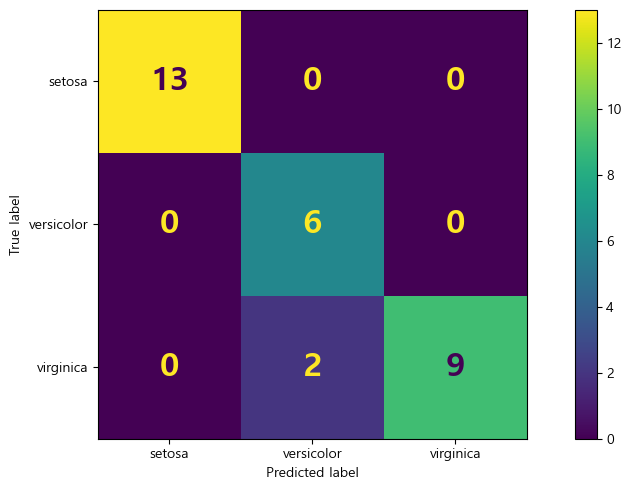


[Roc Curve]


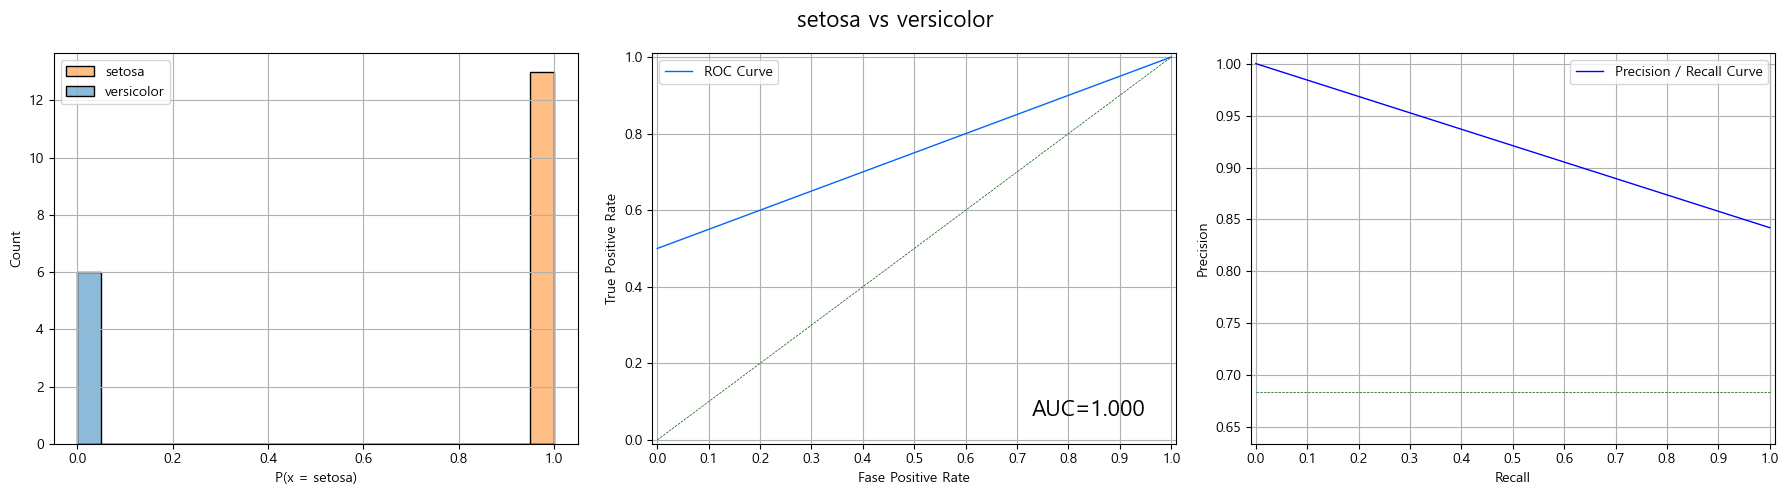

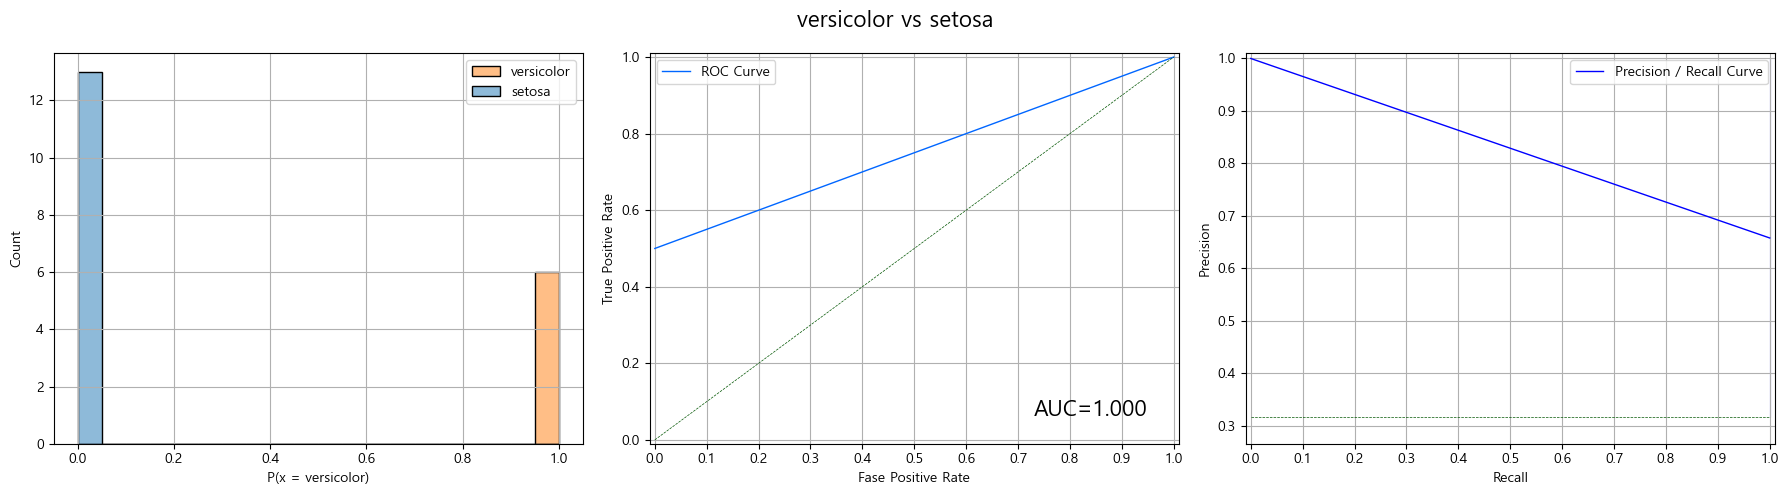

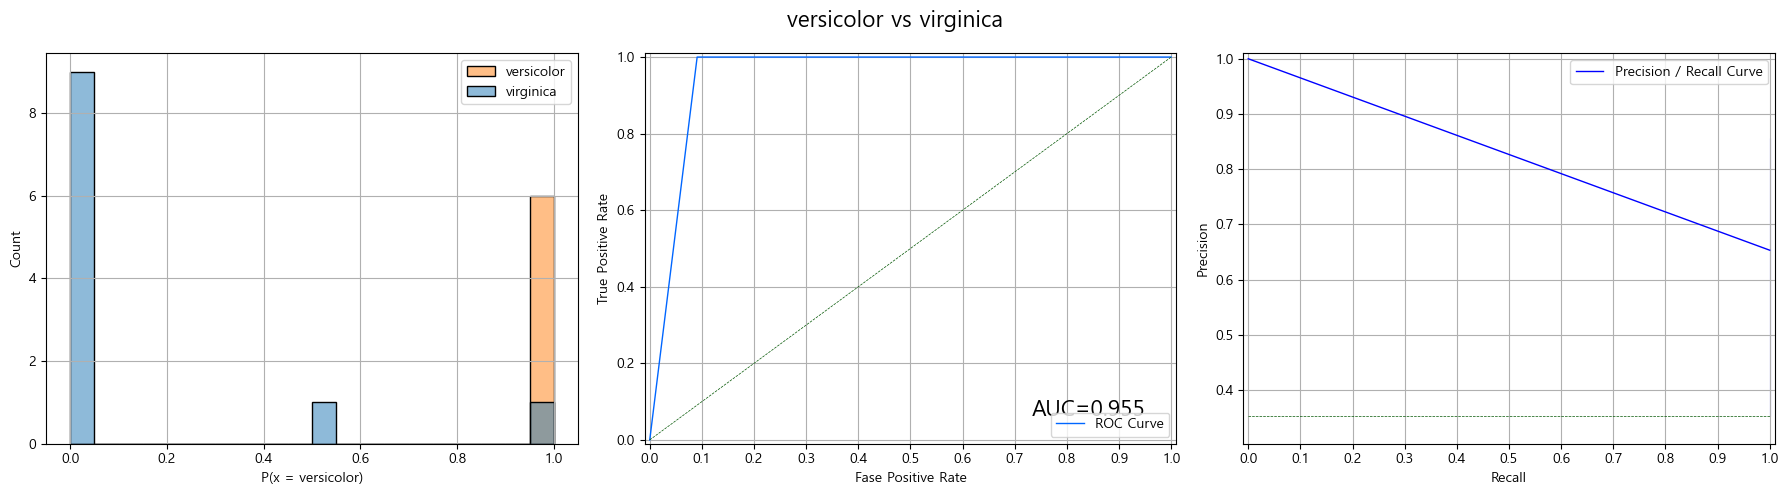

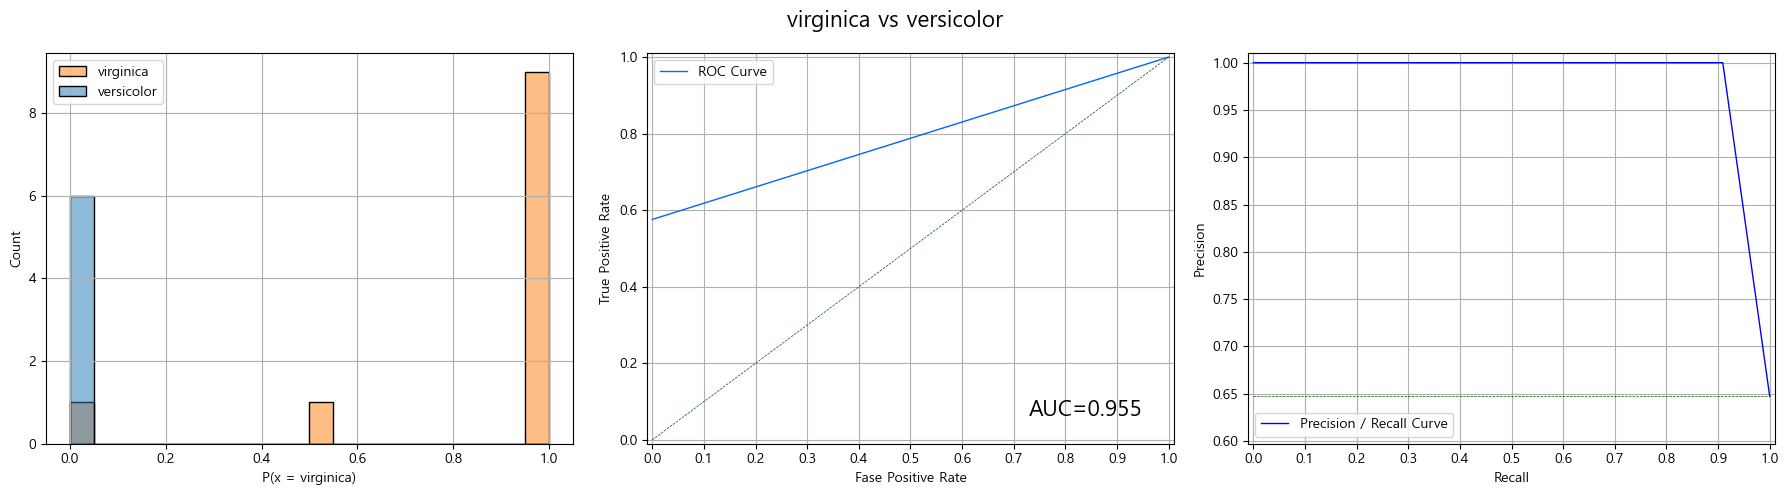

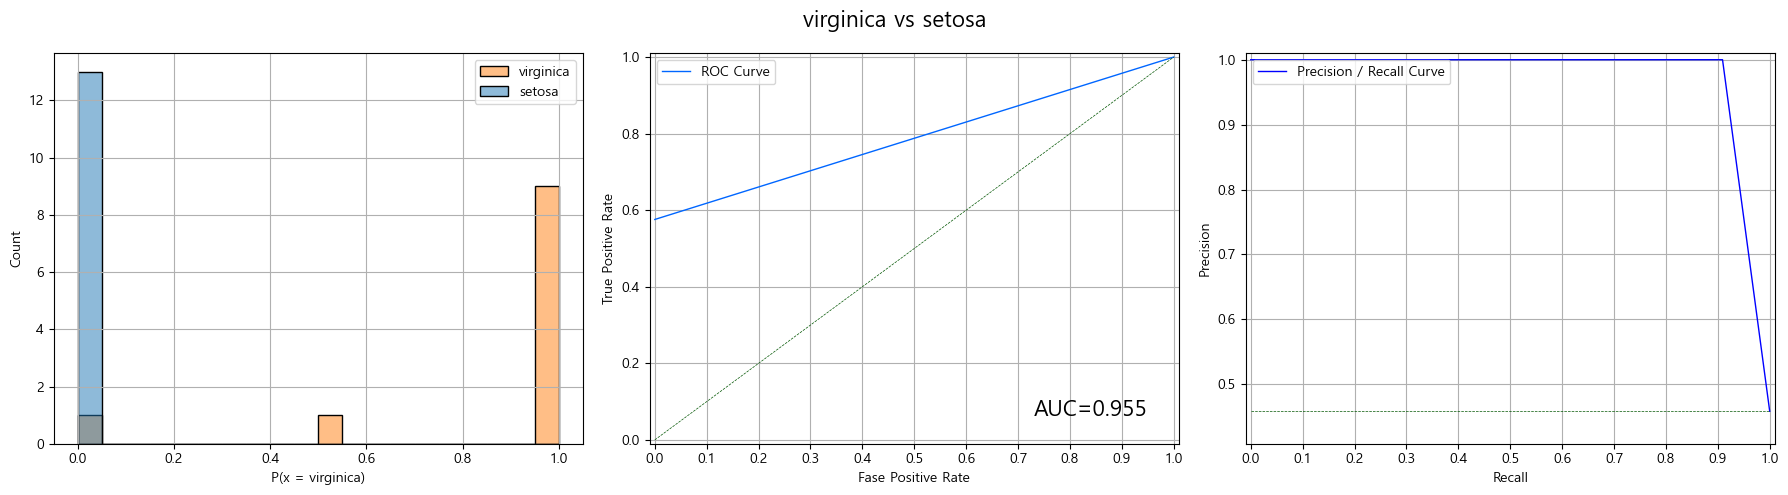

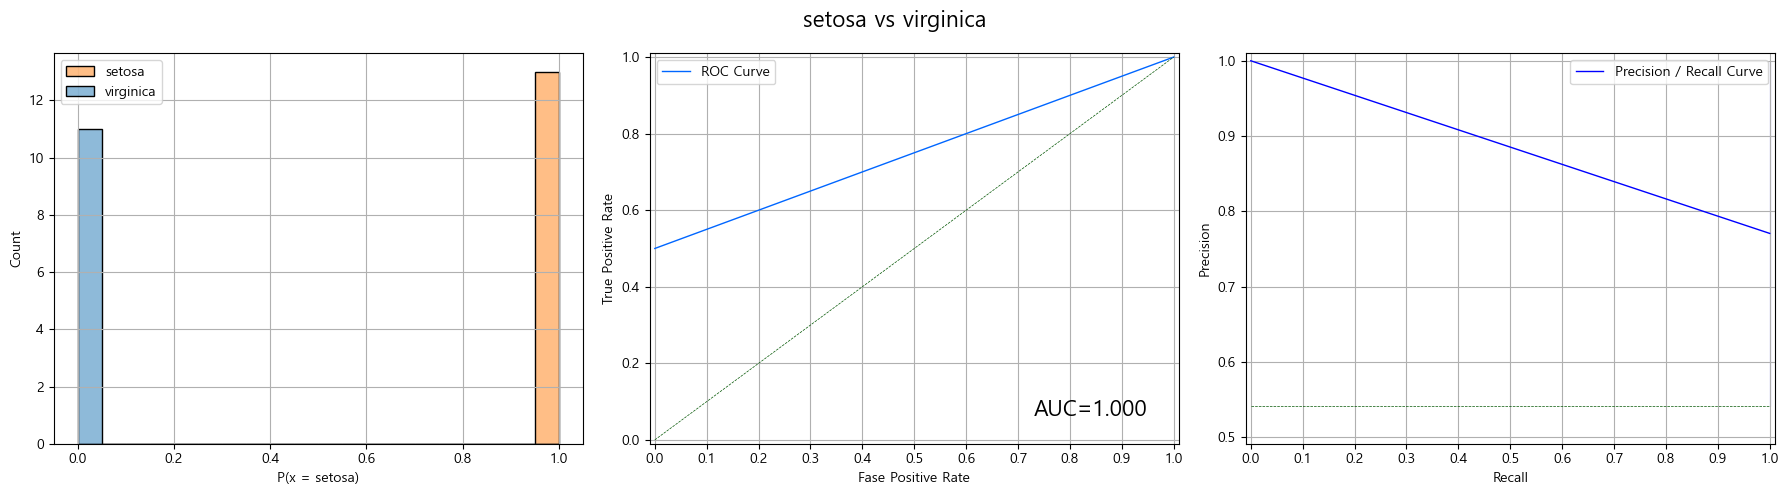

mean roc auc ovo: 0.9773


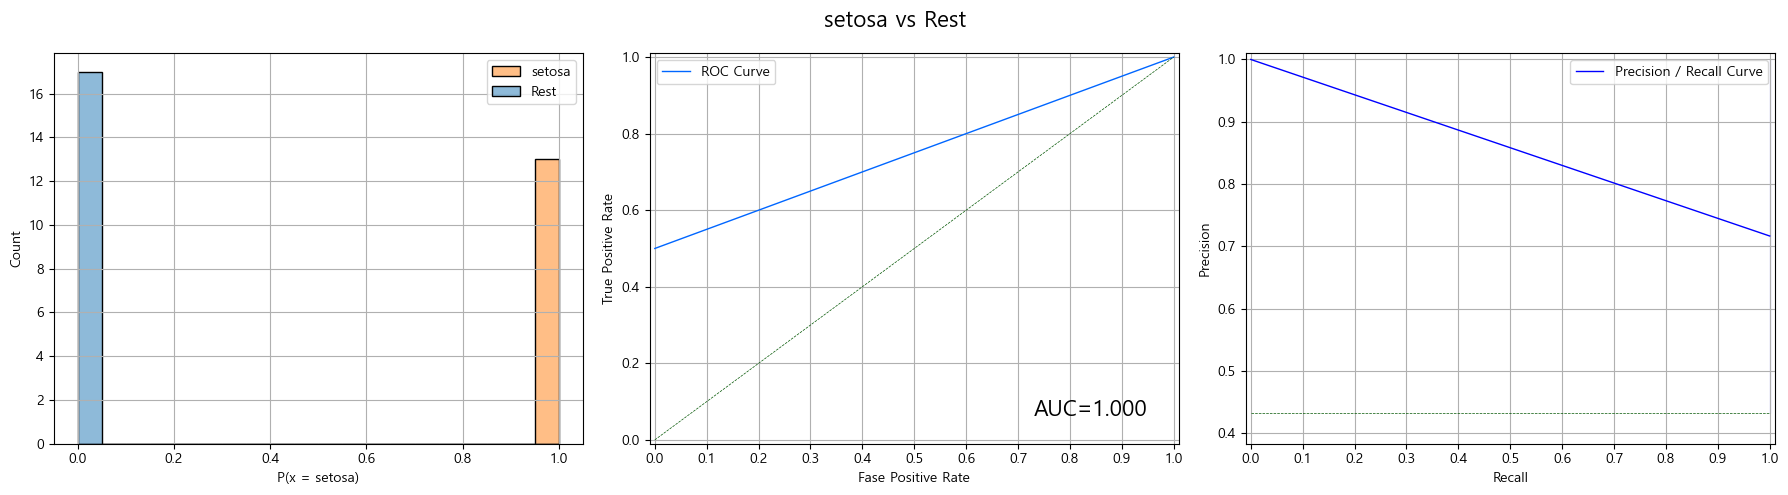

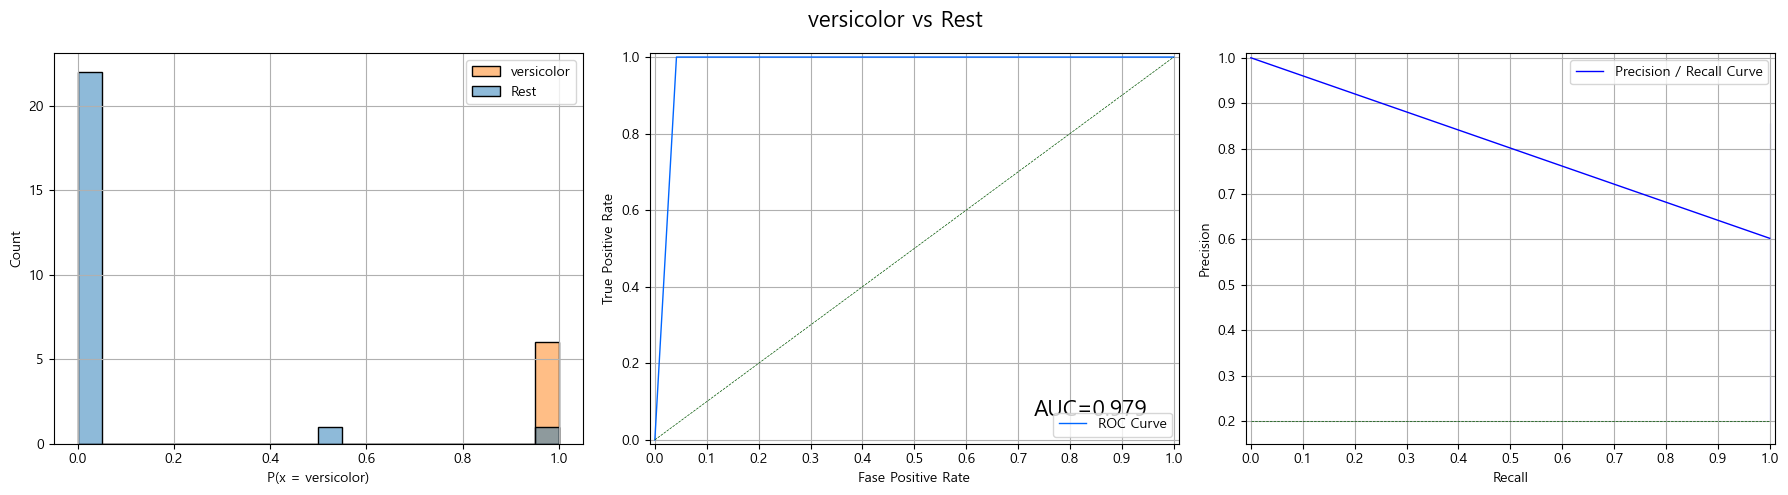

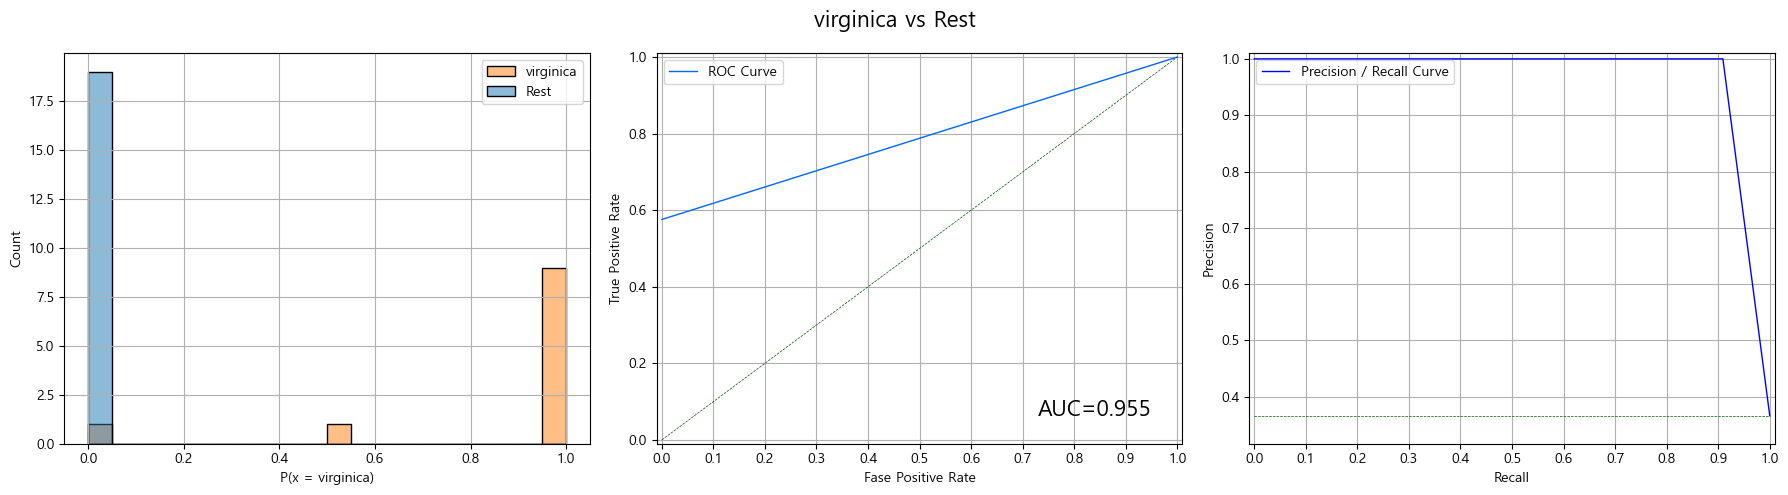

mean roc auc ovo: 0.9779

[학습곡선]


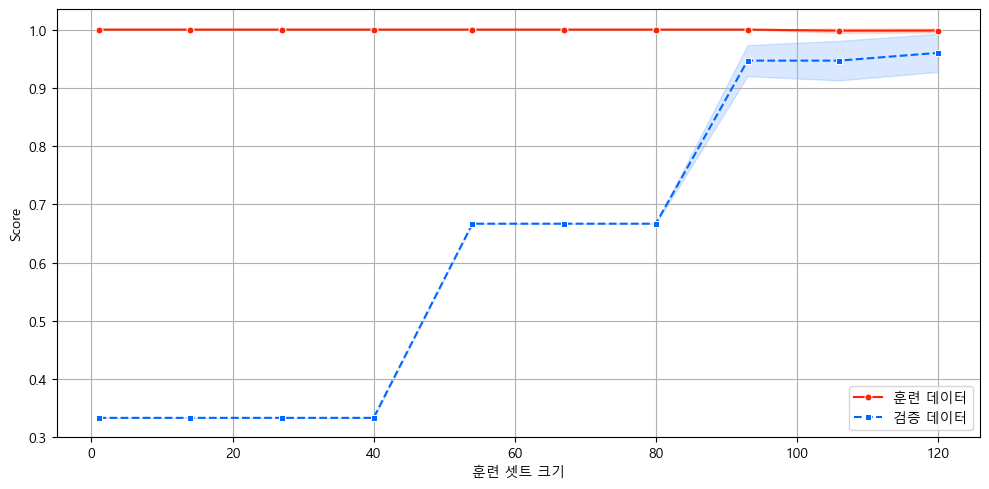

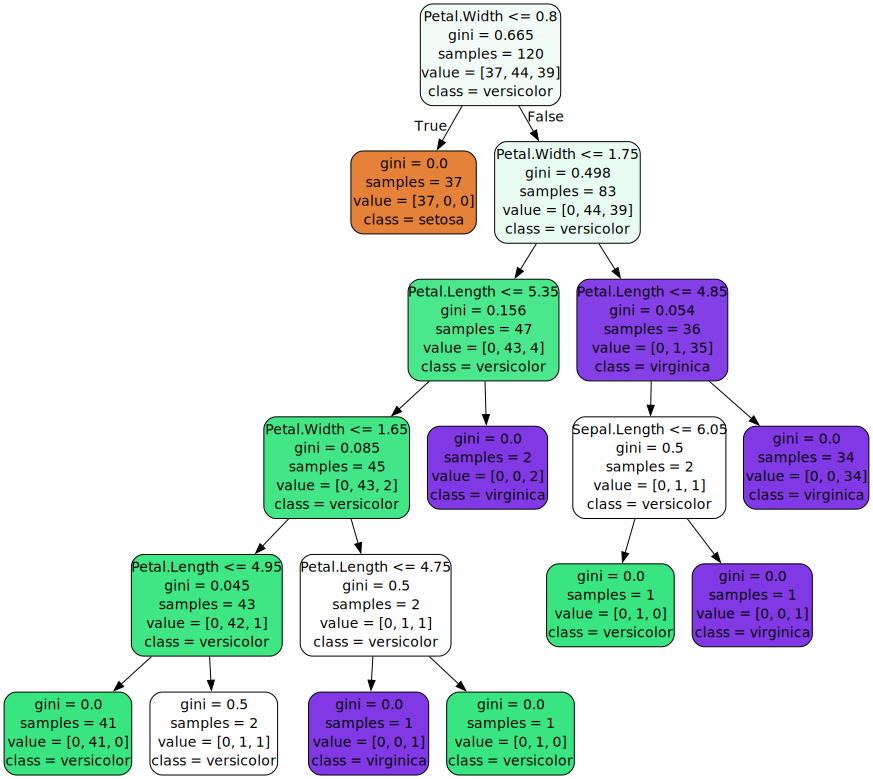

DecisionTreeClassifier(max_depth=5)

In [32]:
my_dtree_classification(x_train, y_train, x_test, y_test)

In [37]:
my_classification(x_train,y_train,x_test,y_test)

<class 'sklearn.naive_bayes.GaussianNB'>는 n_jobs를 허용하지 않음
<class 'sklearn.tree._classes.DecisionTreeClassifier'>는 n_jobs를 허용하지 않음
+------------------------+--------------------+---------------------+------------------+------------+------------+------------+
|                        |   정확도(Accuracy) |   정밀도(Precision) |   재현율(Recall) |   F1 Score |   AUC(ovo) |   AUC(ovr) |
|------------------------+--------------------+---------------------+------------------+------------+------------+------------|
| DecisionTreeClassifier |           0.966667 |            0.952381 |         0.969697 |   0.958486 |   0.977273 |   0.977904 |
| GaussianNB             |           0.966667 |            0.952381 |         0.969697 |   0.958486 |          1 |          1 |
| KNeighborsClassifier   |           0.933333 |            0.914141 |         0.914141 |   0.914141 |   0.989899 |   0.992181 |
| LogisticRegression     |           0.966667 |            0.952381 |         0.969697 |   0.958486 |          

{'DecisionTreeClassifier': DecisionTreeClassifier(),
 'GaussianNB': GaussianNB(),
 'KNeighborsClassifier': KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=7),
 'LogisticRegression': LogisticRegression(C=10, max_iter=1000, n_jobs=1),
 'SVC': SVC(C=1, degree=2, kernel='poly', n_jobs=-1)}